In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from itertools import combinations
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info import Statevector
from docplex.mp.model import Model
from random import random,randint
import warnings
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
from qiskit.optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints by adding slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo    # combines the previous three converters
)
from qiskit.aqua.algorithms.minimum_eigen_solvers.qaoa.var_form import QAOAVarForm
from qiskit.circuit import Parameter
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.aqua.algorithms import QAOA
import time
warnings.filterwarnings('ignore')

# Generate Random Graph

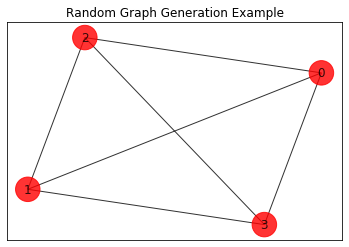

In [14]:
n = 4
p = 0.6
# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

#Generate random graph
def ER(n, p):
    V = set([v for v in range(n)])
    E = set()
    for combination in combinations(V, 2):
        a = random()
        if a < p:
            E.add(combination)

    g = nx.Graph()
    g.add_nodes_from(V)
    g.add_edges_from(E)
    return g
G = ER(n, p)
pos = nx.spring_layout(G)
plot_result(G,[0]*n)
plt.title("Random Graph Generation Example") 
edges = G.edges
e = np.array(list(edges))

# Without Penalty  #######
# Solve Quadratic Program using CPLEX#####



// This file has been generated by DOcplex
// model name is: Vertex cover
// var contrainer section
dvar bool x[4];

minimize
 x0 + x1 + x2 + x3;
 
subject to {
 x0 + x1 >= 1;
 x0 + x3 >= 1;
 x0 + x2 >= 1;
 x1 + x2 >= 1;
 x1 + x3 >= 1;
 x2 + x3 >= 1;

}
optimal function value: 3.0
optimal value: [ 1.  1.  1. -0.]
status: SUCCESS
0.09381985664367676


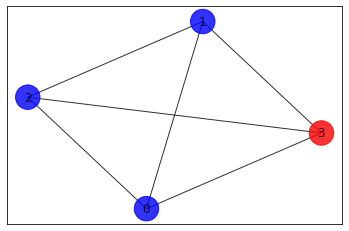

In [15]:


start_time = time.time()
mdl = Model('Vertex cover')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
objective = mdl.sum([ (x[i] ) for i in range(n)])
mdl.minimize(objective)
for (i,j) in edges:
    subjective = mdl.sum([x[i]+x[j]])
    mdl.add_constraint(subjective >=1)
mdl.prettyprint()
# convert from DOcplex model to Qiskit Quadratic Program
qp = QuadraticProgram()
qp.from_docplex(mdl)

cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_result(G, result.x)

end_time = time.time()
print(end_time - start_time)

# Solve Quadratic Program using QAOA

6
10
// This file has been generated by DOcplex
// model name is: Vertex cover
// var contrainer section
dvar bool x[4];

minimize
 x0 + x1 + x2 + x3;
 
subject to {
 x0 + x1 >= 1;
 x0 + x3 >= 1;
 x0 + x2 >= 1;
 x1 + x2 >= 1;
 x1 + x3 >= 1;
 x2 + x3 >= 1;

}
dim(H): (1024, 1024)
[[ -2.   0.   0. ...   0.   0.   0.]
 [  0. -37.   0. ...   0.   0.   0.]
 [  0.   0. -37. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... -35.   0.   0.]
 [  0.   0.   0. ...   0. -35.   0.]
 [  0.   0.   0. ...   0.   0. -70.]]
optimal params:       {Parameter(θ[0]): -1.0119223532751518, Parameter(θ[1]): -0.8393576089509839}
optimal value:        -38.603124459394934
optimal probability:  0.022621480877006682
optimal function value: 3.0
optimal value: [1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]
status: SUCCESS


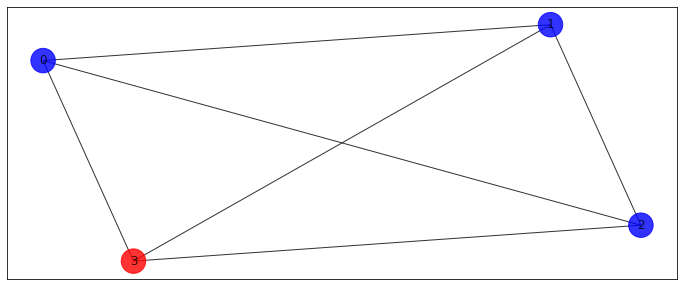

In [16]:
######## Solve Quadratic Program using QAOA######
start_time = time.time()
print(int(e.size/2))
m = n +int(e.size/2)
print(m)
mdl = Model('Vertex cover')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
objective = mdl.sum([ (x[i] ) for i in range(n)])
mdl.minimize(objective)
for (i,j) in edges:
    subjective = mdl.sum([x[i]+x[j]])
    mdl.add_constraint(subjective >=1)
mdl.prettyprint()
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas
# convert from DOcplex model to Qiskit Quadratic Program
qp = QuadraticProgram()
qp.from_docplex(mdl)
lineq2penalty = LinearEqualityToPenalty(penalty = e.size)
ITE = InequalityToEquality('integer')
ITB = IntegerToBinary()
qp = ITB.convert(qp)
qpc = ITE.convert(qp)
qp_wo_constr = lineq2penalty.convert(qpc)
qubo = QuadraticProgramToQubo()
qp_wo_constr = qubo.convert(qp_wo_constr)

H, offset = qp_wo_constr.to_ising()

H_matrix = np.real(H.to_matrix(massive=True))
print('dim(H):', H_matrix.shape)
print(H_matrix)

# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]

  
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas


# construct parameters from annealing schedule
T = 10
N = 20
gammas, betas = construct_schedule(T, N)

# construct variational form
var_form = QAOAVarForm(H, N+1)

# evaluate circuit
qc = var_form.construct_circuit(gammas + betas)
sv = Statevector.from_instruction(qc)
# plot probabilities
probabilities = sv.probabilities()
plt.figure(figsize=(12, 5))
plt.bar(range(2**m), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**m), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**m)], rotation=90, fontsize=14)
plt.yticks(fontsize=14);
gamma, beta = Parameter('gamma'), Parameter('beta')
p = 1
var_form = QAOAVarForm(H, p)
var_form.construct_circuit([gamma, beta]).draw(output='mpl')

def objective(params):
    qc_ = qc.bind_parameters({gamma: params[0], beta: params[1]})
    probs = Statevector.from_instruction(qc_).probabilities()
    return probs @ [1, -1]
optimizer = COBYLA()

qaoa_mes = QAOA(H, p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
result = qaoa_mes.run()

print('optimal params:      ', result.optimal_parameters)
print('optimal value:       ', result.optimal_value)
print('optimal probability: ', sum(np.abs(result.eigenstate[opt_indices])**2))
# construct QAOA as Minimum Eigensolver
qaoa_mes = QAOA(p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

# construct Minimum Eigen Optimizer based on QAOA
qaoa = MinimumEigenOptimizer(qaoa_mes)

# solve Quadratic Program
result = qaoa.solve(qp_wo_constr)
print(result)
plot_result(G, result.x)

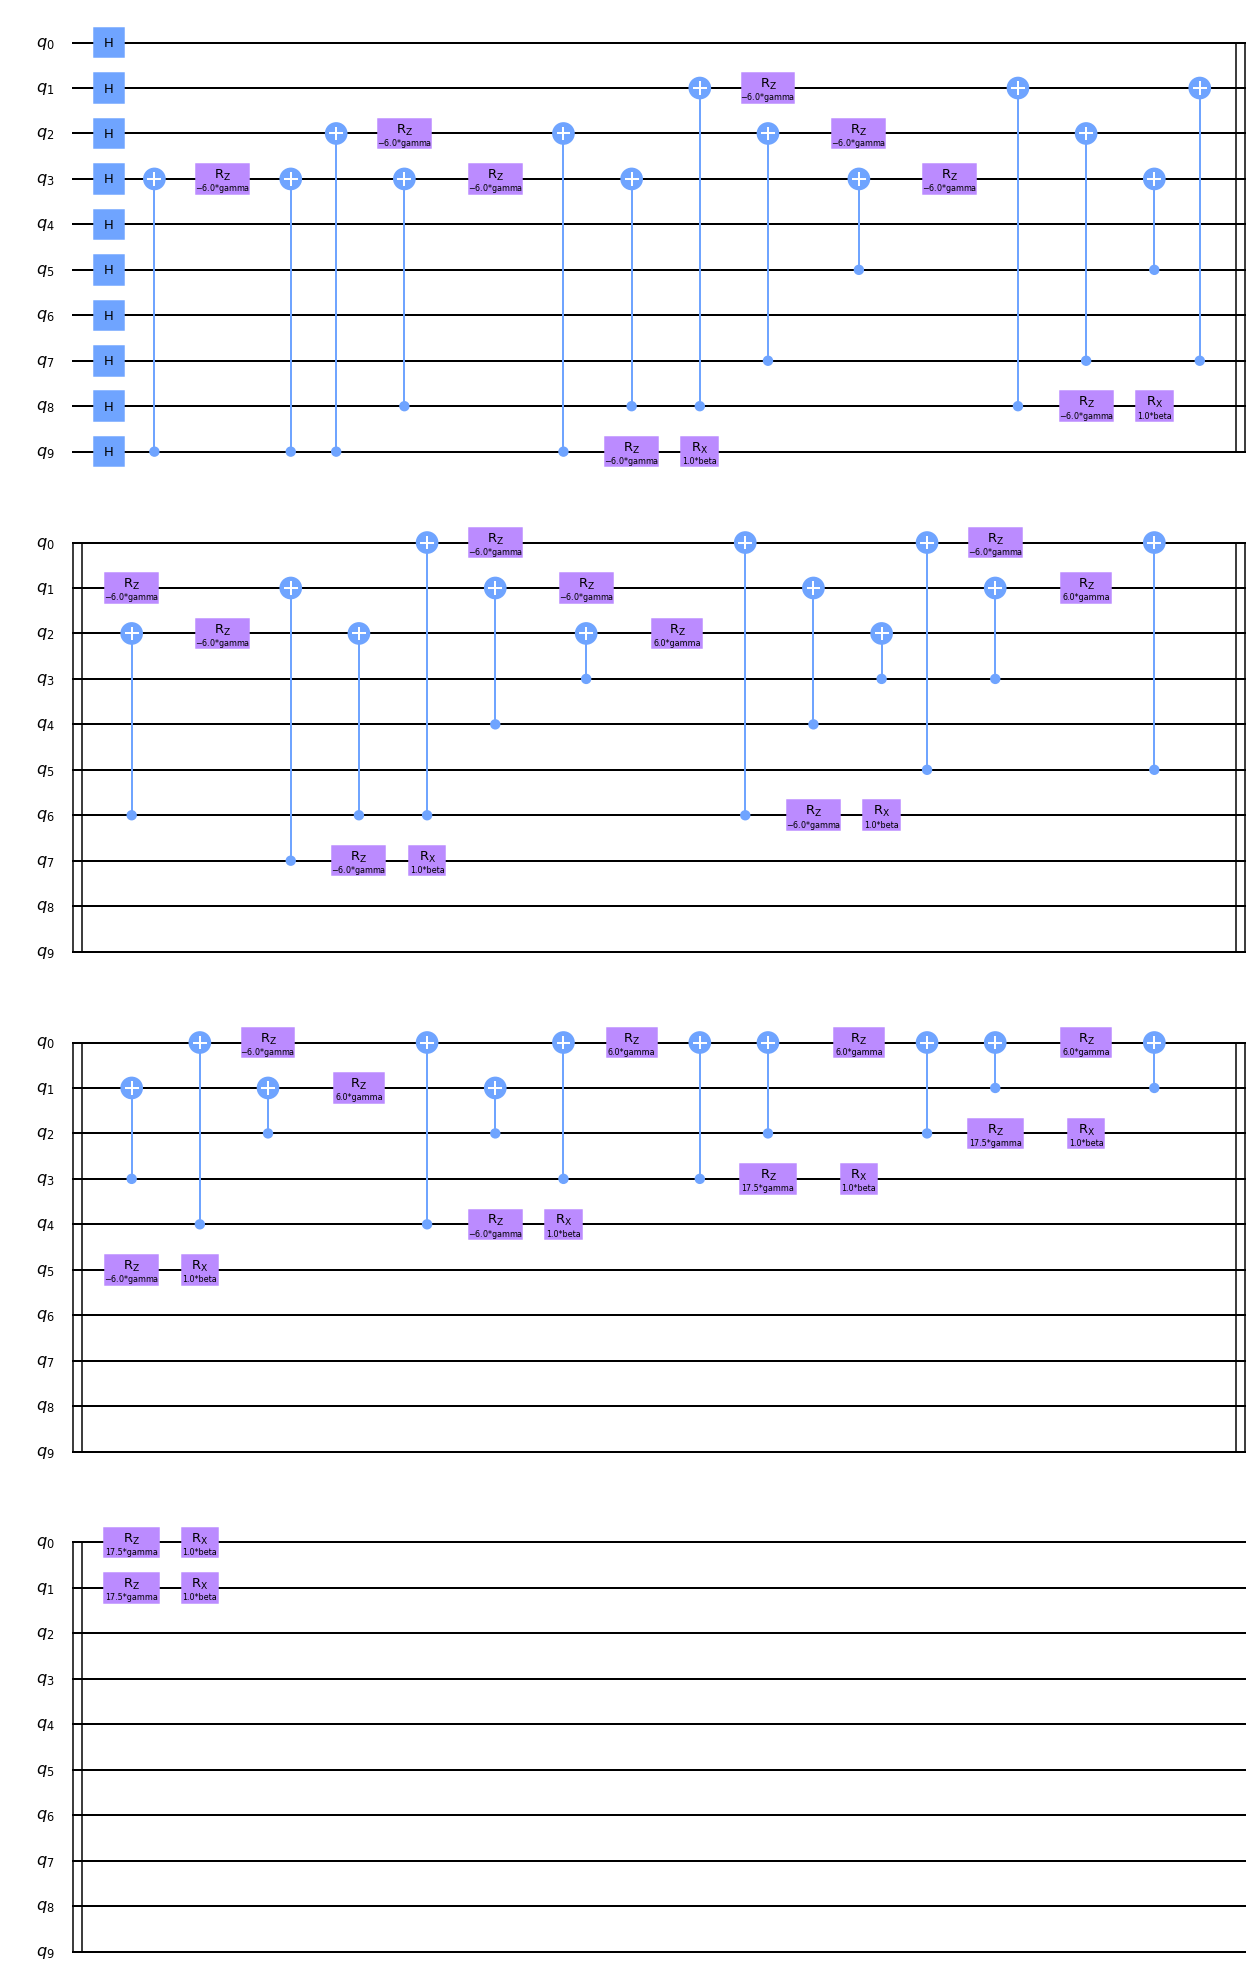

In [18]:
gamma, beta = Parameter('gamma'), Parameter('beta')
p = 1
var_form = QAOAVarForm(H, p)
var_form.construct_circuit([gamma, beta]).draw(output='mpl')

# With Penalty  
# Solve Quadratic Program using CPLEX

// This file has been generated by DOcplex
// model name is: Vertex cover
// var contrainer section
dvar bool x[4];

minimize
 - 35 x0 - 35 x1 - 35 x2 - 35 x3 [ 24 x0*x1 + 24 x0*x2 + 24 x0*x3 + 24 x1*x2
 + 24 x1*x3 + 24 x2*x3 ] + 72;
 
subject to {

}


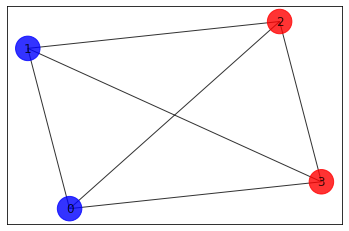

In [17]:
######## With Penalty  #######
######## Solve Quadratic Program using CPLEX######
penalty = e.size
mdlp = Model('Vertex cover')
x = mdlp.binary_var_list('x{}'.format(i) for i in range(n))
objective = mdlp.sum([ (x[i] ) for i in range(n)])
subtoobj = mdlp.sum([(1 - x[i]-x[j]+2*x[i]*x[j]) for (i,j) in edges])
objective1 = mdlp.sum([objective,penalty*subtoobj])

mdlp.minimize(objective1)
mdlp.prettyprint()
# convert from DOcplex model to Qiskit Quadratic Program
qp = QuadraticProgram()
qp.from_docplex(mdlp)

cplex = CplexOptimizer()
result = cplex.solve(qp)
plot_result(G, result.x)



# Solve Quadratic Program using QAOA

// This file has been generated by DOcplex
// model name is: Vertex cover
// var contrainer section
dvar bool x[4];

minimize
 - 35 x0 - 35 x1 - 35 x2 - 35 x3 [ 24 x0*x1 + 24 x0*x2 + 24 x0*x3 + 24 x1*x2
 + 24 x1*x3 + 24 x2*x3 ] + 72;
 
subject to {

}
dim(H): (16, 16)
[[ 34.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0. -12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0. -12.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0. -12.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.

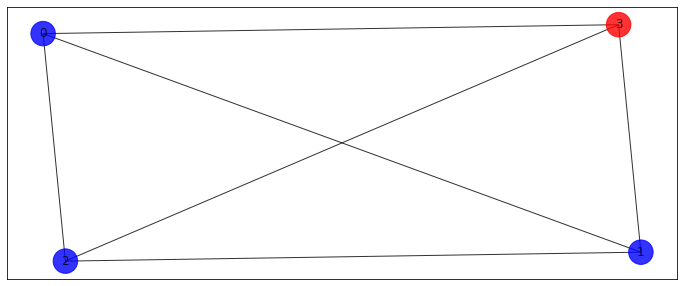

In [18]:
######## With Penalty  #######
######## Solve Quadratic Program using QAOA######
penalty = e.size
mdlp = Model('Vertex cover')
x = mdlp.binary_var_list('x{}'.format(i) for i in range(n))
objective = mdlp.sum([ (x[i] ) for i in range(n)])
subtoobj = mdlp.sum([(1 - x[i]-x[j]+2*x[i]*x[j]) for (i,j) in edges])
objective1 = mdlp.sum([objective,penalty*subtoobj])

mdlp.minimize(objective1)
mdlp.prettyprint()
# convert from DOcplex model to Qiskit Quadratic Program
qp = QuadraticProgram()
qp.from_docplex(mdlp)



H, offset = qp.to_ising()

H_matrix = np.real(H.to_matrix(massive=True))
print('dim(H):', H_matrix.shape)
print(H_matrix)

# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]

  
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas


# construct parameters from annealing schedule
T = 10
N = 20
gammas, betas = construct_schedule(T, N)

# construct variational form
var_form = QAOAVarForm(H, N+1)

# evaluate circuit
qc = var_form.construct_circuit(gammas + betas)
sv = Statevector.from_instruction(qc)
# plot probabilities
probabilities = sv.probabilities()
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14);
gamma, beta = Parameter('gamma'), Parameter('beta')
p = 1
var_form = QAOAVarForm(H, p)
var_form.construct_circuit([gamma, beta]).draw('mpl')
def objective(params):
    qc_ = qc.bind_parameters({gamma: params[0], beta: params[1]})
    probs = Statevector.from_instruction(qc_).probabilities()
    return probs @ [1, -1]
optimizer = COBYLA()

qaoa_mes = QAOA(H, p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
result = qaoa_mes.run()

print('optimal params:      ', result.optimal_parameters)
print('optimal value:       ', result.optimal_value)
print('optimal probability: ', sum(np.abs(result.eigenstate[opt_indices])**2))
# construct QAOA as Minimum Eigensolver
qaoa_mes = QAOA(p=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

# construct Minimum Eigen Optimizer based on QAOA
qaoa = MinimumEigenOptimizer(qaoa_mes)

# solve Quadratic Program
result = qaoa.solve(qp_wo_constr)
print(result)
plot_result(G, result.x)


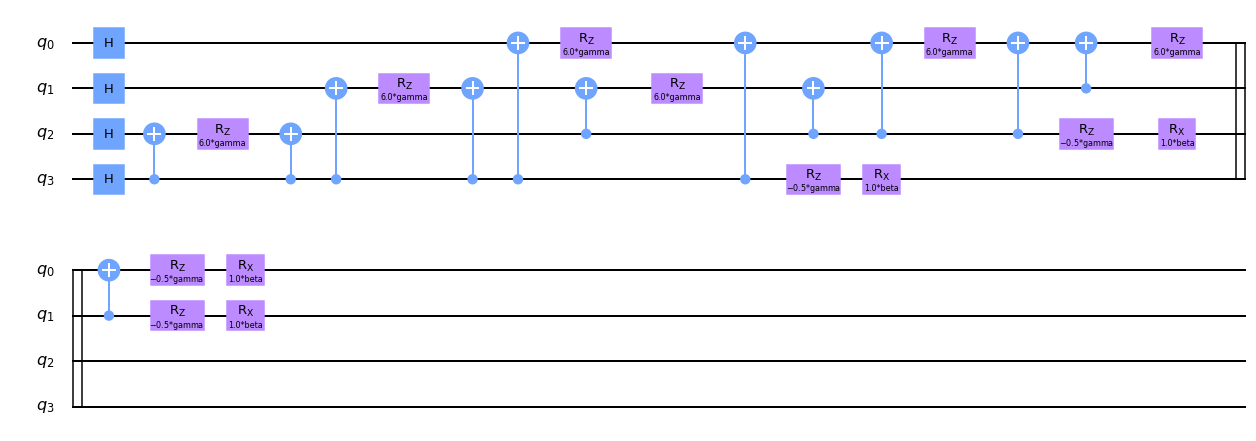

In [19]:
gamma, beta = Parameter('gamma'), Parameter('beta')
p = 1
var_form = QAOAVarForm(H, p)
var_form.construct_circuit([gamma, beta]).draw(output='mpl')